In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [2]:
embedding_layer = layers.Embedding(1000, 5)

In [3]:
result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()

array([[ 0.02497326,  0.01106883, -0.00975877,  0.02509773,  0.04539246],
       [-0.04722118, -0.03266098, -0.02645617, -0.03906427,  0.02959434],
       [ 0.04884605, -0.03903381, -0.02899837,  0.03219323, -0.02307898]],
      dtype=float32)

In [4]:
result.shape

TensorShape([3, 5])

In [8]:
(train_data, test_data), info = tfds.load(
    "imdb_reviews/subwords8k",
    split=(tfds.Split.TRAIN, tfds.Split.TEST),
    with_info=True, as_supervised=True
)

Shuffling and writing examples to /home/kitamura/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteC344KG/imdb_reviews-train.tfrecord


Shuffling and writing examples to /home/kitamura/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteC344KG/imdb_reviews-test.tfrecord


Shuffling and writing examples to /home/kitamura/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteC344KG/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /home/kitamura/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [10]:
encoder = info.features["text"].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [14]:
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=([None], []))
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=([None], []))

In [15]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[  62,    9,  547, ...,    0,    0,    0],
       [  12,  346, 7968, ...,    0,    0,    0],
       [2510,   63, 1899, ...,    0,    0,    0],
       ...,
       [ 324,   12,   18, ...,    0,    0,    0],
       [5467,  644, 7968, ...,    0,    0,    0],
       [ 274, 2732, 1289, ...,    0,    0,    0]])

In [20]:
train_batch.shape

TensorShape([10, 709])

In [22]:
embedding_dim = 16

model = keras.Sequential([
    layers.Embedding(encoder.vocab_size, embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=["accuracy"])
history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20
)

Epoch 1/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.5199 - accuracy: 0.6838 - val_loss: 0.3983 - val_accuracy: 0.8450
Epoch 2/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.2896 - accuracy: 0.8799 - val_loss: 0.2967 - val_accuracy: 0.8800
Epoch 3/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.2355 - accuracy: 0.9067 - val_loss: 0.3992 - val_accuracy: 0.8500
Epoch 4/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.2024 - accuracy: 0.9218 - val_loss: 0.3795 - val_accuracy: 0.8150
Epoch 5/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1784 - accuracy: 0.9336 - val_loss: 0.4915 - val_accuracy: 0.8300
Epoch 6/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1622 - accuracy: 0.9390 - val_loss: 0.3597 - val_accuracy: 0.8600
Epoch 7/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1451 - accuracy: 0.9460 - val_loss: 0.3491 - val_accuracy:

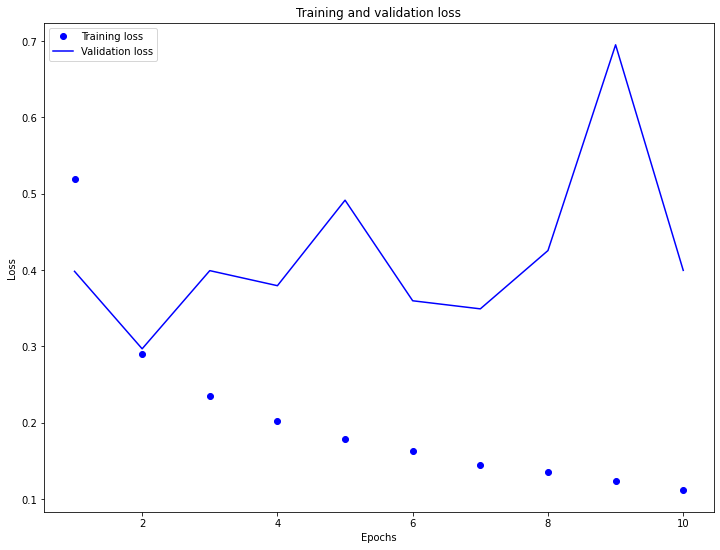

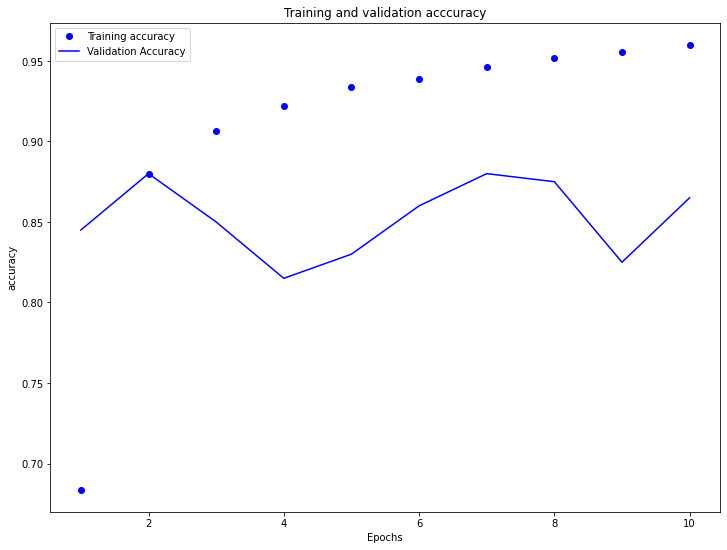

In [34]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title("Training and validation acccuracy")
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [40]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(8185, 16)


In [45]:
import io

encoder = info.features['text'].encoder
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
    vec = weights[num + 1]
    out_m.write(word + '\n')
    out_v.write('\t'.join([str(x) for x in vec]))
out_v.close()
out_m.close()

In [44]:
weights.shape

(8185, 16)